In [21]:
# REQUIRED IMPORTS FROM STANDARD PACKAGES

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import random
import pandas as pd
from os.path import join as pjoin
from glob import glob
import sklearn as sk
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
import scipy
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.externals.joblib import parallel_backend
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile, f_classif, chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
#news
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve

# IMPORTS FROM THE UTIL LIBRARY PROVIDED BY US

import util.vis as V
import util.helpers as H

# Normally, all libraries are loaded only once, 
# even if you execute the import code multiple times
# This code is helpful if you make your own helper libraries 
%load_ext autoreload
%autoreload 1
# list your libraries below with aimport: should ensure 
#they are reloaded each time without having to restart your kernel
# in this case, our libraries are used as an example

%aimport util.helpers, util.vis
%aimport features_extraction
%aimport augmentation
%aimport Analysis
%aimport validation
%aimport preprocessing

# seed random generator such that this notebook always returns the same values 
# (this is by no means necessary, but it is useful for reproducability of results)
rng = np.random.RandomState(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# PATHS

DATA_DIR = '../../Phase 1/data'
POSE_DIR = '../../Phase 1/data/pose'

# PATHS

DATA_DIR = '../data'
POSE_DIR = '../data/pose'

## Loading data
Loading all the training and test data

In [7]:
def keep_sample(sample):
    counter = 0
    no_hands_present = False
    for frame in sample:
        if (frame[4][0] == 0 or frame[7][0] == 0):
            counter += 1
        if (frame[4][0] == 0 and frame[7][0] == 0):
            no_hands_present = True
    if counter/len(sample) > 0.5 or no_hands_present:
        return False
    else:
        return True
##Loading all the training data
dataset_file=pjoin(DATA_DIR,'labels.csv')

train_samples=[]
train_labels=[]
train_persons = []
train_personlabels = []

with open(dataset_file) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    sample_index = 0
    preprocessing_outliers = [229, 297, 1316, 1780, 1817, 49, 495, 541, 746, 878, 2910]
    outliers_jens_fixing_gap1 = [85 , 398 , 717 , 766 , 923 , 979 ,1111 ,1280 ,1671 ,1778 ,1960 ,1993 ,2038 ,2089, 2097, 2135 ,2140, 2145, 2417 ,2463 ,2554 ,2579, 2594, 2794, 2832 ,2975, 3138, 3211, 3215, 3325 ,3341 ,3396 ,3399 ,3482 ,3566, 3649, 3702]
    outliers_jens_fixing_gap2 = [264,322,578,592,663,717,766,770,885,888,894,901,906,917,923,933,949,954,964,979,986,1117,1151,1152,1159,1161,1171,1199,1227,1257,1297,1573,1600,1607,1665,1671,1684,1701,1767,1778,1831,1859,1883,1930,1931,1932,1943,1960,1972,1993,1999,2037,2050,2056,2060,2089,2091,2097,2106,2119,2135,2140,2167,2191,2209,2231,2232,2235,2260,2268,2289,2334,2336,2538,2551,2554,2579,2602,2614,2637,2683,2688,2694,2699,2726,2741,2787,2803,2810,2841,2844,2845,2848,2887,2888,2893,2902,2943,2947,2954,2967,2975,2984,2990,3037,3064,3073,3078,3087,3103,3118,3119,3136,3138,3149,3170,3283,3293,3298,3305,3332,3342,3435,3475,3482,3561,3589,3590,3621,3629,3641,3649,3658,3672,3693,3697,3699,3702,3709,3710]
    outliers_robbe_fixing_gap = [2538, 1753, 1327, 2954, 2956, 2958, 4, 1111, 1117, 1118, 2167, 1992, 1993, 1573, 1575, 1576, 977, 245, 1846, 1909, 2435, 2545, 2590, 2815, 3515, 396, 421, 434, 494, 676, 718, 795, 815, 821, 882, 977, 991, 1016, 1035, 1111, 1295, 1308, 1524, 1564, 1586, 1633, 1634, 1804]
    for row in reader: 
        name, _gloss, label, _person = row
        sample = np.load(pjoin(POSE_DIR, 'train', name+'.npy'))
        #if (sample_index not in preprocessing_outliers) and (sample_index not in outliers_jens_fixing_gap1) and (sample_index not in outliers_jens_fixing_gap2) and (sample_index not in outliers_robbe_fixing_gap):            
        if keep_sample(sample):
            train_samples.append(sample)
            train_labels.append(int(label))
            train_persons.append(_person)
            train_personlabels.append((label, _person))
        sample_index += 1

train_samples=np.array(train_samples)
train_labels=np.array(train_labels)

##Loading all the test data
all_test_files = sorted(glob(pjoin(POSE_DIR, 'test', '*.npy')))  

test_samples = []
for numpy_file in all_test_files:
    sample = np.load(numpy_file)
    test_samples.append(sample)
    
test_samples = np.array(test_samples)

## Data augmentation

In [8]:
"""
train_samples = augmentation.augment_data(train_samples)
train_labels = np.concatenate(( train_labels,train_labels, train_labels))
train_persons = np.concatenate(( train_persons,train_persons, train_persons))
train_personlabels = np.concatenate(( train_personlabels,train_personlabels, train_personlabels))
"""

'\ntrain_samples = augmentation.augment_data(train_samples)\ntrain_labels = np.concatenate(( train_labels,train_labels, train_labels))\ntrain_persons = np.concatenate(( train_persons,train_persons, train_persons))\ntrain_personlabels = np.concatenate(( train_personlabels,train_personlabels, train_personlabels))\n'

## Data preprocessing

In [9]:
train_samples = preprocessing.centering(train_samples)
test_samples = preprocessing.centering(test_samples)

--- Centering finished ---
--- Centering finished ---


## Extracting features

In [10]:
#Train data
df = features_extraction.extract_features(train_samples)
X_train = df.values
y_train = np.array(train_labels)
#Test data
X_test = features_extraction.extract_features(test_samples).values
#Number of total features
num_features = X_train.shape[1]
print("Number of features : ", num_features)
#Correlation Matrix
#Analysis.plot_correlation_matrix(df)

D:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\main\Documents\ML_competition\features_extraction.py:1243: RuntimeWarning: invalid value encountered in true_divide
  ve

Number of features :  869


## Loss functions
Custom scoring functions

In [11]:
##Custom scoring functions

def top3_acc_score(y_true, proba):
    return H.mapk(proba,y_true)

def map3_score(y_true, proba):
    return H.top3_accuracy(proba, y_true)
    

acc = make_scorer(accuracy_score)
top3_acc = make_scorer(top3_acc_score, needs_proba=True) 
map3 = make_scorer(map3_score, needs_proba=True)
scoring_functions = {"acc": acc, "top3_acc": top3_acc, "map3": map3}

## Validation strategy

In [12]:
##Train validate data splitter for Cross Validation
seed = np.random.randint(1,999)
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)

## Pipeline & model training

In [36]:
# the function below generates our rescaled pipeline model
# with optimized hyperparameters (e.g.: regularisation parameter)
def tune_adaBoost(x_data,r_data,verbose=0):
    pipe = Pipeline([
        ('scale', StandardScaler()), 
        ('selectkbest', SelectKBest(f_classif)), 
        ('adaboost',AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4,min_samples_split=0.1, 
            min_samples_leaf = 0.1, max_features=110, class_weight='balanced', random_state=24)))
        #('tree', DecisionTreeClassifier(random_state=24, class_weight='balanced'))
    ])
    """
    #tuning decisionTree
    max_depth = laag houden want anders overfitten < 10
    min_samples_split < 0.5
    min_samples_leaf < 0.3
    max_features
    """
    # Set the parameters by cross-validation
    tuned_parameters_tree = {'tree__max_depth': np.arange(2, 6, 1), #4
                             'tree__min_samples_split': np.arange(0.1, 0.2, 0.1),#0.1
                             'tree__min_samples_leaf': np.arange(0.1, 0.2, 0.1),#0.1
                             'tree__max_features': np.arange(50, 150, 10),#110
                             'selectkbest__k': np.arange(150, 250, 10)#220
                            }
    tuned_parameters_ensemble = {'adaboost__n_estimators':np.arange(200, 300, 20),
                                 'adaboost__learning_rate':np.logspace(-3, -1, 4), 
                                 'selectkbest__k': np.arange(250, 350, 20)
                                }

    print("------ Start tuning hyperparameters ------")
    CV = GridSearchCV(pipe, tuned_parameters_ensemble, n_jobs=-1, scoring=map3, pre_dispatch='n_jobs', cv=sgkf, verbose=2)
    print(CV)
    with parallel_backend('threading'):
        CV.fit(x_data, r_data)
    print("------ Tuning hyperparameters finished ------")
    
    #Tuning ensemble
    bestEstimator = CV.best_params_['adaboost__n_estimators']
    bestLR = CV.best_params_['adaboost__learning_rate']
    bestK = CV.best_params_['selectkbest__k']
    print("Optimal n estimators: ", bestEstimator)
    print("Optimal Learning Rate: ", bestLR)
    print("Optimal k value: ", bestK)
    """
    
    bestDepth = CV.best_params_['tree__max_depth']
    bestSplit = CV.best_params_['tree__min_samples_split']
    bestLeaf = CV.best_params_['tree__min_samples_leaf']
    bestFeatures = CV.best_params_['tree__max_features']
    bestK = CV.best_params_['selectkbest__k']
    print("Optimal Depth: ", bestDepth)
    print("Optimal Split: ", bestSplit)
    print("Optimal Leaf: ", bestLeaf)
    print("Optimal Features: ", bestFeatures)
    print("Optimal K: ", bestK)
    """
    optimal_pipe = Pipeline([
        ('scale', StandardScaler()), 
        ('selectkbest', SelectKBest(f_classif,k=bestK)),
        ('adaboost',AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4,class_weight='balanced', min_samples_split=0.1,
                    min_samples_leaf=0.1, max_features=110),n_estimators=bestEstimator,learning_rate=bestLR,random_state=24))
        #('tree', DecisionTreeClassifier(random_state=24,class_weight='balanced',max_depth=bestDepth, min_samples_split=bestSplit, min_samples_leaf=bestLeaf, max_features=bestFeatures))
        ])
    
    optimal_pipe.fit(x_data,r_data)  
    
    if verbose>0:
    
        print("Grid scores on training data set:")
        print()
        cv_means = CV.cv_results_['mean_test_score']
        print(cv_means)
        cv_stds = CV.cv_results_['std_test_score']
        for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    return optimal_pipe, CV.cv_results_

In [37]:
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
optimal_pipe, res = tune_adaBoost(X_train, y_train, 1)
print('---------Optimal pipe finished -----------')
##Train validate data splitter for Cross Validation
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)

with parallel_backend('threading'):
    scores = cross_val_score(optimal_pipe, X_train, y_train, scoring=map3, cv=sgkf, n_jobs=-1, pre_dispatch='n_jobs')
print(scores)
print("Average (cross validated) map@3 score: ",scores.mean(),", stdev: ",scores.std())

optimal_pipe.fit(X_train, y_train)

------ Start tuning hyperparameters ------
GridSearchCV(cv=<generator object stratified_group_k_fold at 0x0000025B606FB048>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x0000025B561EA1E0>)), ('adaboost', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criteri...24,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'adaboost__n_estimators': array([200, 220, 240, 260, 280]), 'adaboost__learning_rate': array([0.001  , 0.00464, 0.02154, 0.1    ]), 'selectkbest__k': array([250, 270, 290, 310, 330])},
       pre_dispatch='n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(map3_score, needs_proba=True), verbose

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=200, selectkbest__k=270, total=  28.3s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=200, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=200, selectkbest__k=250, total=  28.9s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=200, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=200, selectkbest__k=250, total=  29.2s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=200, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=200, selectkbest__k=250, total=  29.3s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=200, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=200, selectkbest__k=270, total=  29.3s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=200, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=200, selectkbest__k=250, 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min


[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=220, selectkbest__k=270, total=  30.7s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=220, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=220, selectkbest__k=270, total=  30.8s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=220, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=220, selectkbest__k=290, total=  30.6s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=220, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=220, selectkbest__k=290, total=  31.1s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=220, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=220, selectkbest__k=290, total=  30.9s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=220, selectkbest__k=330 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=220, selectkbest__k=290, 

[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=260, selectkbest__k=250, total=  36.5s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=260, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=260, selectkbest__k=250, total=  36.1s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=260, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=260, selectkbest__k=270, total=  36.1s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=260, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=260, selectkbest__k=270, total=  35.5s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=260, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=260, selectkbest__k=270, total=  35.6s
[CV] adaboost__learning_rate=0.001, adaboost__n_estimators=260, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=260, selectkbest__k=270, 

[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=280, selectkbest__k=330, total=  37.8s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=200, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=280, selectkbest__k=330, total=  37.7s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=200, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=200, selectkbest__k=250, total=  27.5s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=200, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.001, adaboost__n_estimators=280, selectkbest__k=330, total=  38.1s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=200, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=200, selectkbest__k=250, total=  27.6s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=200, 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.2min


[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=220, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=220, selectkbest__k=250, total=  30.5s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=220, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=220, selectkbest__k=270, total=  30.4s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=220, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=220, selectkbest__k=270, total=  30.1s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=220, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=220, selectkbest__k=270, total=  30.3s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=220, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.00464158883361277

[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=240, selectkbest__k=310, total=  32.4s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=260, selectkbest__k=250 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=240, selectkbest__k=310, total=  32.2s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=260, selectkbest__k=250 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=240, selectkbest__k=310, total=  33.4s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=260, selectkbest__k=250 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=240, selectkbest__k=330, total=  32.7s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=260, selectkbest__k=250 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=240, selectkbest__k=330, total=  32.7s
[CV] adaboost__learning_rate=0.004

[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=280, selectkbest__k=270, total=  39.0s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=280, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=280, selectkbest__k=270, total=  37.7s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=280, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=280, selectkbest__k=270, total=  38.4s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=280, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=280, selectkbest__k=270, total=  38.5s
[CV] adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=280, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.004641588833612777, adaboost__n_estimators=280, selectkbest__k=290, total=  39.0s
[CV] adaboost__learning_rate=0.004

[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=200, selectkbest__k=330, total=  28.8s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=220, selectkbest__k=250 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=200, selectkbest__k=330, total=  27.6s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=220, selectkbest__k=250 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=200, selectkbest__k=330, total=  27.6s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=220, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=200, selectkbest__k=330, total=  28.5s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=220, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=200, selectkbest__k=330, total=  27.6s
[CV] adaboost__learning_rate=0.021

[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=240, selectkbest__k=270, total=  33.7s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=240, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=240, selectkbest__k=290, total=  34.6s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=240, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=240, selectkbest__k=290, total=  33.6s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=240, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=240, selectkbest__k=290, total=  33.3s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=240, selectkbest__k=330 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=240, selectkbest__k=290, total=  34.0s
[CV] adaboost__learning_rate=0.021

[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=260, selectkbest__k=330, total=  36.0s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=260, selectkbest__k=330, total=  36.5s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=250, total=  39.3s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=250, total=  38.9s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=250, total=  39.0s
[CV] adaboost__learning_rate=0.021

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 26.1min


[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=270, total=  38.5s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=270, total=  39.6s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=270, total=  39.4s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=290, total=  39.4s
[CV] adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=310 
[CV]  adaboost__learning_rate=0.021544346900318832, adaboost__n_estimators=280, selectkbest__k=290, total=  39.4s
[CV] adaboost__learning_rate=0.021

[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=220, selectkbest__k=250, total=  31.5s
[CV] adaboost__learning_rate=0.1, adaboost__n_estimators=220, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=220, selectkbest__k=250, total=  31.5s
[CV] adaboost__learning_rate=0.1, adaboost__n_estimators=220, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=220, selectkbest__k=250, total=  31.5s
[CV] adaboost__learning_rate=0.1, adaboost__n_estimators=220, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=220, selectkbest__k=250, total=  31.4s
[CV] adaboost__learning_rate=0.1, adaboost__n_estimators=220, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=220, selectkbest__k=270, total=  31.2s
[CV] adaboost__learning_rate=0.1, adaboost__n_estimators=220, selectkbest__k=290 
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=220, selectkbest__k=270, total=  31.4s
[CV] ada

[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=240, selectkbest__k=330, total=  34.4s
[CV] adaboost__learning_rate=0.1, adaboost__n_estimators=260, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=240, selectkbest__k=330, total=  34.5s
[CV] adaboost__learning_rate=0.1, adaboost__n_estimators=260, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=240, selectkbest__k=330, total=  33.9s
[CV] adaboost__learning_rate=0.1, adaboost__n_estimators=260, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=260, selectkbest__k=250, total=  37.8s
[CV] adaboost__learning_rate=0.1, adaboost__n_estimators=260, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=260, selectkbest__k=250, total=  37.7s
[CV] adaboost__learning_rate=0.1, adaboost__n_estimators=260, selectkbest__k=270 
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=260, selectkbest__k=250, total=  36.9s
[CV] ada

[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=280, selectkbest__k=310, total=  40.3s
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=280, selectkbest__k=330, total=  39.6s
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=280, selectkbest__k=330, total=  38.7s
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=280, selectkbest__k=330, total=  40.3s
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=280, selectkbest__k=330, total=  38.7s
[CV]  adaboost__learning_rate=0.1, adaboost__n_estimators=280, selectkbest__k=330, total=  37.8s


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 37.1min finished
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


------ Tuning hyperparameters finished ------
Optimal n estimators:  240
Optimal Learning Rate:  0.021544346900318832
Optimal k value:  290
Grid scores on training data set:

[0.65337079 0.65561798 0.66573034 0.66741573 0.66685393 0.65898876
 0.66573034 0.66376404 0.66853933 0.66573034 0.66264045 0.66657303
 0.66207865 0.66544944 0.66825843 0.66825843 0.6741573  0.66825843
 0.6755618  0.67696629 0.6755618  0.6744382  0.6747191  0.68286517
 0.67837079 0.71320225 0.70758427 0.71320225 0.71264045 0.71095506
 0.71573034 0.71544944 0.71657303 0.71460674 0.71573034 0.71573034
 0.70870787 0.71432584 0.71853933 0.71910112 0.71320225 0.71966292
 0.72359551 0.71769663 0.71882022 0.71741573 0.72106742 0.72078652
 0.71769663 0.72106742 0.72780899 0.7252809  0.72275281 0.72275281
 0.72921348 0.72050562 0.71882022 0.72724719 0.73146067 0.72724719
 0.71713483 0.7252809  0.73539326 0.72949438 0.7255618  0.72022472
 0.73146067 0.7255618  0.7261236  0.73342697 0.72162921 0.72134831
 0.72837079 0.7255618

[0.74110953 0.7132964  0.74043716 0.69806094 0.74302496]
Average (cross validated) map@3 score:  0.7271857986125325 , stdev:  0.01822921114596862


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=290, score_func=<function f_classif at 0x0000025B561EA1E0>)), ('adaboost', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criter...best'),
          learning_rate=0.021544346900318832, n_estimators=240,
          random_state=24))])

In [38]:
index_best_fit = 62
train_score_CV = [res['split0_train_score'][index_best_fit], res['split1_train_score'][index_best_fit], res['split2_train_score'][index_best_fit], res['split3_train_score'][index_best_fit], res['split4_train_score'][index_best_fit]]
val_score_CV = [res['split0_test_score'][index_best_fit], res['split1_test_score'][index_best_fit], res['split2_test_score'][index_best_fit], res['split3_test_score'][index_best_fit], res['split4_test_score'][index_best_fit]]
print("Train",train_score_CV, "averaged: ", np.mean(train_score_CV))
print("Val",val_score_CV, "averaged: ", np.mean(val_score_CV))

Train [0.9135456772838642, 0.9175475687103594, 0.9091230551626591, 0.9059196617336153, 0.9023966655088572] averaged:  0.9097065256798711
Val [0.7596017069701281, 0.7202216066481995, 0.7636612021857924, 0.6911357340720221, 0.7430249632892805] averaged:  0.7355290426330845


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are acc

In [102]:
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
with parallel_backend('threading'):
    train_scores_2, valid_scores_2 = validation_curve(optimal_pipe, X_train, y_train, "adaboost__learning_rate", np.logspace(-3, 3, 25), cv=sgkf, scoring=map3, n_jobs=-1, pre_dispatch='n_jobs')

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value en

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value en

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value en

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value en

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning:

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:531: RuntimeWarning: invalid value e

In [86]:
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
with parallel_backend('threading'):
    train_scores, valid_scores = validation_curve(optimal_pipe, X_train, y_train, "adaboost__n_estimators", np.arange(100, 350, 10), cv=sgkf, scoring=map3, n_jobs=-1, pre_dispatch='n_jobs')

In [100]:
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
with parallel_backend('threading'):
    train_scoresK, valid_scoresK = validation_curve(optimal_pipe, X_train, y_train, "selectkbest__k", np.arange(110, 350, 10), cv=sgkf, scoring=map3, n_jobs=-1, pre_dispatch='n_jobs')

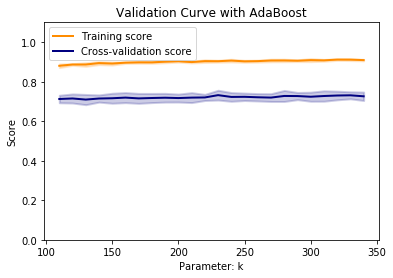

In [101]:
train_scores_mean = np.mean(train_scoresK, axis=1)
train_scores_std = np.std(train_scoresK, axis=1)
test_scores_mean = np.mean(valid_scoresK, axis=1)
test_scores_std = np.std(valid_scoresK, axis=1)

plt.title("Validation Curve with AdaBoost")
plt.xlabel("Parameter: k")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
param_range = np.arange(110, 350, 10)
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

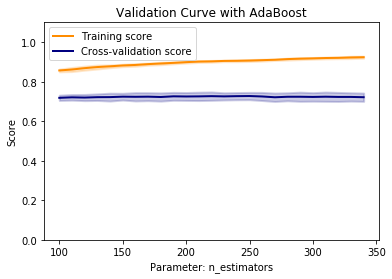

In [96]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with AdaBoost")
plt.xlabel("Parameter: n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
param_range=np.arange(100, 350, 10)
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

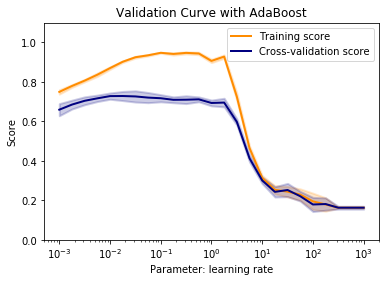

In [103]:
train_scores_mean = np.mean(train_scores_2, axis=1)
train_scores_std = np.std(train_scores_2, axis=1)
test_scores_mean = np.mean(valid_scores_2, axis=1)
test_scores_std = np.std(valid_scores_2, axis=1)

plt.title("Validation Curve with AdaBoost")
plt.xlabel("Parameter: learning rate")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
param_range=np.logspace(-3, 3, 25)
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

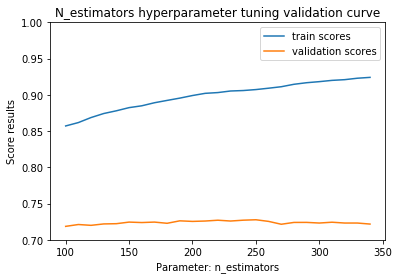

In [90]:
valid_means = [np.mean(i) for i in valid_scores]
train_means = [np.mean(i) for i in train_scores]

plt.plot(np.arange(100, 350, 10), train_means, label="train scores")
plt.plot(np.arange(100, 350, 10), valid_means, label="validation scores")
axes = plt.axes()
axes.set_ylim([0.7, 1])
plt.xlabel("Parameter: n_estimators")
plt.ylabel("Score results")
plt.title("N_estimators hyperparameter tuning validation curve")
plt.legend()



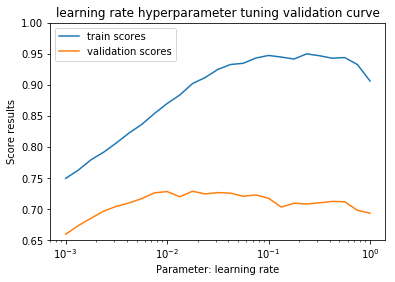

In [92]:
valid_means_2 = [np.mean(i) for i in valid_scores_2]
train_means_2 = [np.mean(i) for i in train_scores_2]


plt.plot(np.logspace(-3, 0, 25), train_means_2, label="train scores")
plt.plot(np.logspace(-3, 0, 25), valid_means_2, label="validation scores")
axes = plt.axes()
axes.set_ylim([0.65, 1])
plt.xscale("log")
plt.xlabel("Parameter: learning rate")
plt.ylabel("Score results")
plt.title("learning rate hyperparameter tuning validation curve")
plt.legend()



## Generate kaggle submission file

In [39]:
test_probas = optimal_pipe.predict_proba(X_test)
H.create_submission(test_probas, 'adaboost2_kbest_Tuned.csv')

## Model analysis
Generate confusion matrix on validation data

In [ ]:
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5)
with parallel_backend('threading'):
    y_pred = cross_val_predict(optimal_pipe, X_train, y_train, cv=sgkf, n_jobs=-1, pre_dispatch='n_jobs')
Analysis.plot_confusion_matrix(confusion_matrix(y_train, y_pred))

Calculate the precision, recall, F1 score, TP, FP and NP

In [ ]:
##ANALYSIS
train_probas = optimal_pipe.predict_proba(X_train)
prob_order = H.get_ordered_predictions(train_probas)
# Get the top prediction per sample.
top_prob = prob_order[:,:1]
top_prob_2= prob_order[:,1:2]
top_prob_3= prob_order[:,2:3]

target_names = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
print('k 1')
print(classification_report(y_train, top_prob, target_names=target_names))
print('k 2')
print(classification_report(y_train, top_prob_2, target_names=target_names))
print('k 3')
print(classification_report(y_train, top_prob_3, target_names=target_names))
        
